# Projeto Final - Compressão de imagem com unsupervised learning

**Nome: Eduardo Henrique Dias Melgaço  
Matrícula: 2017023501**

## Introdução

O objetivo desse projeto é colocar em prática a implementação de algoritmos que utilizam o processo de aprendizado não supervisionado e avaliar sua performance na tarefa de compressão de imagem. Atualmente, existem duas formas de classificar técnicas de compressão de imagem, **lossy** e **lossless**. Em uma compressão do tipo *lossy*, a imagem original não pode ser recuperado, enquanto em uma compressão *lossless* elas podem.  
Ambos algoritmos de compressão de dados são do tipo *lossy*, ou seja, haverá perda de dados após a compressão. À partir disso, devemos selecionar o modelo que miniminiza o tamanho em KB e maximiza a qualidade da imagem gerada.  
Para desempenhar esta tarefa, foi utilizado os algoritmos **K-means** e o **Principal Component Analysis (PCA)**.

### Bibliotecas Utilizadas

In [98]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA, IncrementalPCA
from yellowbrick.cluster import KElbowVisualizer
import os
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt

### Funções de utilidade
Abaixo encontramos a implementação de quatro funções de utilidade que são utilizadas no experimento:
- `get_image_size_kb`: Retorna o tamanho de uma imagem em KB;
- `normalize`: Normaliza uma array com valores numéricos para estarem contidos entre 0 e 1.
- `plot_img`: Plota uma imagem na tela e salva um arquivo com essa imagem, caso ela não seja a imagem base nos experimentos e à partir do arquivo calcula o tamanho do arquivo e quanto de redução de tamanho foi obtido;
- `plot_images_comparison`: Exibe um grid com 6 imagens para comparações futuras.

In [111]:
def get_image_size_kb(image_path):
    size = file_stats = os.stat(image_path).st_size
    
    return (size / 1024)

def normalize(values):
    return (values - values.min()) / (values.max() - values.min())

def plot_img(ax, img, title, is_base_img=False):
        ax.imshow(img, interpolation='nearest')
        ax.set_title(title)
        ax.set_yticks([]), ax.set_xticks([])
        if(is_base_img == True):
            ax.set_xlabel("size: %d KB" % (base_img_size))
        else:
            image_name = "%s.jpg" % title
            matplotlib.image.imsave(image_name, img)
            compressed_size = get_image_size_kb(image_name)
            shrink_percent = 100 - (compressed_size / base_img_size * 100) 
            ax.set_xlabel("size: %d KB, (size reduction: %.2f%%)" % (compressed_size, shrink_percent))

            
def plot_images_comparison(images_data):
    fig, axes = plt.subplots(2,3, figsize=(20, 10))
    flat_axes = np.array(axes).flatten()
    
    for i, image_data in enumerate(images_data):
        ax = flat_axes[i]
        is_base_img = i == 0
        image, title = image_data
        plot_img(ax, image, title, is_base_img=is_base_img)
            
        
    plt.show()

## Características da Imagem

A imagem escolhida é a foto que possui várias cores e vários elementos. À partir do arquivo da foto, transformamos ele em um array com três dimensões, que também pode ser visto como um array bidimensional de pixels, onde cada píxel possui 3 entradas Red, Green e Blue. Cada uma dessas entradas possui valores de 0 à 255, que indica o nível de intensidade de cada cor para o pixel em questão. À seguir, será exibido o formato da imagem, o número de cores únicas que ela possui, e o seu tamanho em KB:

In [109]:
BASE_IMG_PATH = 'colorful_city.jpg'
img = Image.open(BASE_IMG_PATH)
total_number_colors = len(set((img.getdata())))
base_img_size = get_image_size_kb(BASE_IMG_PATH)
base_image_array = np.array(img)

print("Formato do array da imagem: ", base_image_array.shape)
print("Número de cores únicas na imagem: ", total_number_colors)
print("Tamanho da imagem: %d KB" % base_img_size)

Formato do array da imagem:  (576, 1024, 3)
Número de cores únicas na imagem:  284292
Tamanho da imagem: 137 KB


## K-means 
O K-means é um algoritmo utilizado para o agrupamento de dados, sua principal utilidade é conseguir agrupar os dados de acordo com um K fornecido. A sua implementação consiste em:
- Escolher randomicamente a posição de K pontos, que são chamados de centróides;
- Calcular a distância de todos os pontos para cada centróide;
- assinalar cada ponto ao centróide mais próximo;
- Após isso, ele recalcula a posição dos centróides seguindo a seguinte função de custo, que deve ser minimizada:
    $$z_i = argmin||x_i - \mu_c||^2$$
    Onde $z_i$ representa um cluster, $x_i$ é um ponto no conjunto de dados e $\mu_c$ é um dos K centróides.
    
A posição inicial dos centróides escolhidos influencia no resultado final. Uma forma de evitar que os resultados sejam afetados por mal posicionamento dos centróides iniciais é através da utilização do K-means++, uma modificação do K-means que busca maximizar a distância entre pontos. Por sorte, biblioteca sklearn utiliza o K-means++ por padrão em sua implementação.
### Compressão de imagem utilizando o K-means
Utilizando o K-means, selecionamos k grupos, onde cada grupo é uma cor que mais se aproxima de um determinado grupo de cores. A partir deste grupo de cores selecionadas, podemos exibir um versão da imagem com o número limitado de cores.

Antes de treinarmos o nosso modelo para agrupar N cores diferentes em cada um de seus clusters, devemos mudar o formato da imagem de forma a ser compatível com o K-means. Como explicado anteriormente uma imagem é representado por uma matriz 2x2 de pixels, onde cada pixel possui 3 entradas RGB, o que produz uma matriz de 3 dimensões e para utilizar o K-means, precisamos de uma matriz bidimensional que pode ser obtida através da multiplicação da altura da imagem pelo seu comprimento.  
À seguir podemos ver o formato original da imagem e seu valor transformado:

In [18]:
reshaped_img = (base_image_array / 255.0).reshape(-1, 3)
print("Formato da imagem: ", base_image_array.shape)
print("Formato da imagem transformada: ",  reshaped_img.shape)

Formato da imagem:  (576, 1024, 3)
Formato da imagem transformada:  (589824, 3)


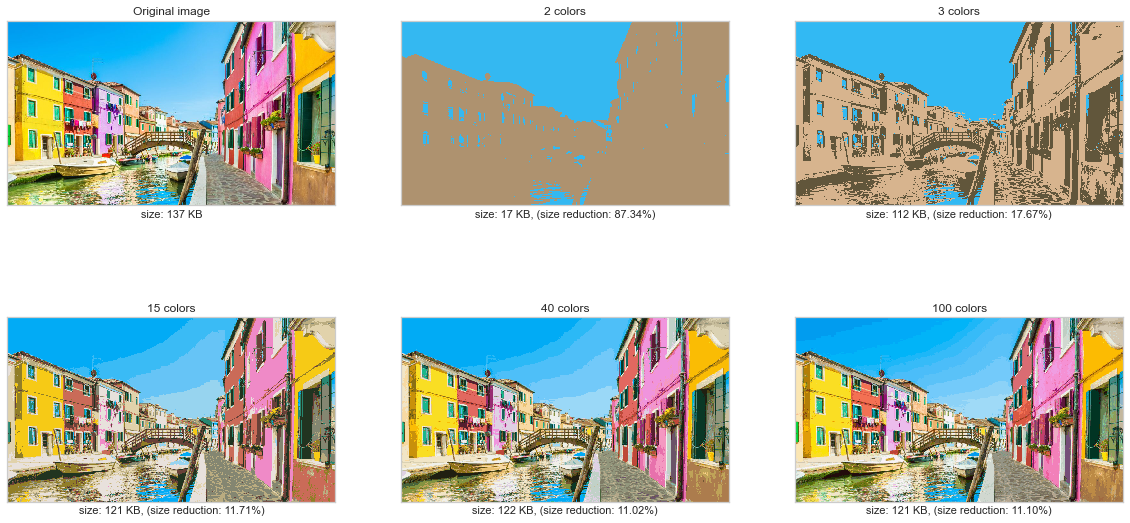

In [121]:
num_colors = [2, 3, 15, 40, 100]
images_data = []

images_data.append([base_image_array, 'Original image'])

for i, num_color in enumerate(num_colors):
    kmeans = MiniBatchKMeans(n_clusters=num_color, random_state=42).fit(reshaped_img)
    k_colors = kmeans.cluster_centers_[kmeans.predict(reshaped_img)]
    k_img = np.reshape(k_colors, (base_image_array.shape))
    images_data.append([k_img, "%d colors" % num_color])

plot_images_comparison(images_data)

Com base nas imagens geradas acima, podemos perceber que a medida que adicionamos mais cores, a imagem gerada se aproxima da imagem original, apesar de aumentar o seu tamanho em KBites. Nas últimas imagens é perceptível que o gradiente presente no céu da cidade é segmentado e cria faixas que mudam de tonalidade. Esse gradiente ocorre justamente por causa da implementação do K-means, que para cada segmento do céu encontra um representante para um intervalo de cores presente.

### Selecionando o melhor valor de K
À seguir será exibido uma metologia utilizado para selecionar o melhor valor de k, que melhor reconhece os grupos de cores essenciais para reconstruir a imagem de forma fiel e que possui o menor tamanho.  
Para selecionar esse valor de K, utilizamos o **Elbow Method** que seleciona o maior valor de k que possui a menor distorção. A distorção é caculada à partir da soma dos erros de cada cluster:
$$distortion = \sum (\mu_c - x_i)^2$$

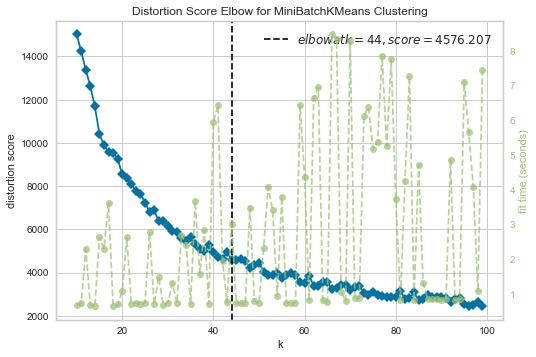

In [101]:
model = MiniBatchKMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(10,100))

visualizer.fit(reshaped_img)
visualizer.show()

No bloco acima, utilizamos o método de elbow visualizer da biblioteca `yellowbrick` para encontrar o valor ótimo de K, que maximiza K enquanto minimiza a distorção. À seguir iremos exibir uma comparação entre a imagem que utiliza esse valor ótimo e a imagem original:

[]

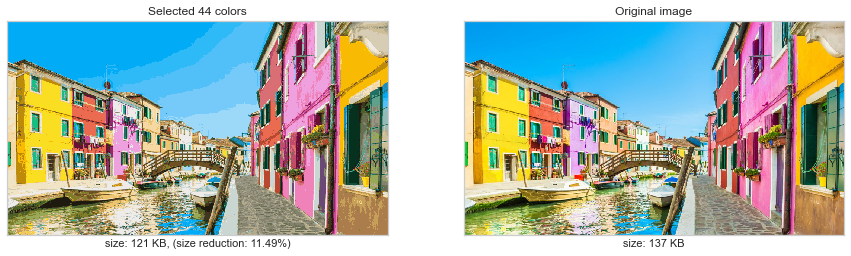

In [104]:
best_k = visualizer.elbow_value_

kmeans = MiniBatchKMeans(n_clusters=best_k).fit(reshaped_img)
k_colors = kmeans.cluster_centers_[kmeans.predict(reshaped_img)]
k_img = np.reshape(k_colors, (base_image_array.shape))

_, ax = plt.subplots(1,2, figsize=(15, 8))
plot_img(ax[0], k_img, 'Selected %d colors' % best_k)
plot_img(ax[1], base_image_array, 'Original image', is_base_img=True)
plt.plot()


A imagem gerada acima é próxima da original e apresenta uma redução de tamanho relativamente boa.

## Principal Component Analysis (PCA)

O PCA é um algoritmo amplamente utilizado para redução de dimensionalidade em conjuntos de dados que possuem muitas features. Em linhas gerais, o seu algoritmo consiste em:
- Calcular o valor mediano de cada feature
- À partir da média de cada feature, encontrar uma média global que representa o centro dos dados;
- Após isso, ele desloca todos os dados de forma a colocar o ponto central em (0,0)
- Por fim, o algoritmo calcula o vetor que mais bem descreve estes dados, ou seja, o vetor que minimiza a distância entre cada ponto e a sua projeção. Estes vetores são chamados de *eigenvectors* e a soma da distância entre os dados e o *eigenvector* é chamado de *eigenvalue*.
- Por fim, caso haja mais de um componente, outro *eigenvector* é traçado de forma a ser perpendicular ao vetor construído, e os dados são projetado em cada um dos *eigenvectors*, de forma que fique visível a contribuição (variação) que cada Principal Component possui em relação aos dados projetados.

### Compressão de imagem usando PCA
Para realizar a tarefa de comprimir uma imagem, a abordagem utilizada à seguir é separar as camadas Red, Green e Blue da imagem e criar um PCA que processa cada uma delas. Após isso, executamos o PCA e obtemos um array com dimensão igual ao `n_components` escolhido, que é invertido novamente para a dimensão original da imagem, de forma a "restaurar" o dado comprimido. O PCA foi implementado com o módulo `IncrementalPCA` que otimiza o espaço de vetores e possui uma performance melhor à implementação padrão do PCA. À seguir, será exibido um comparativo entre cada imagem e o seu tamanho em memória a medida que aumentamos o número de componentes:

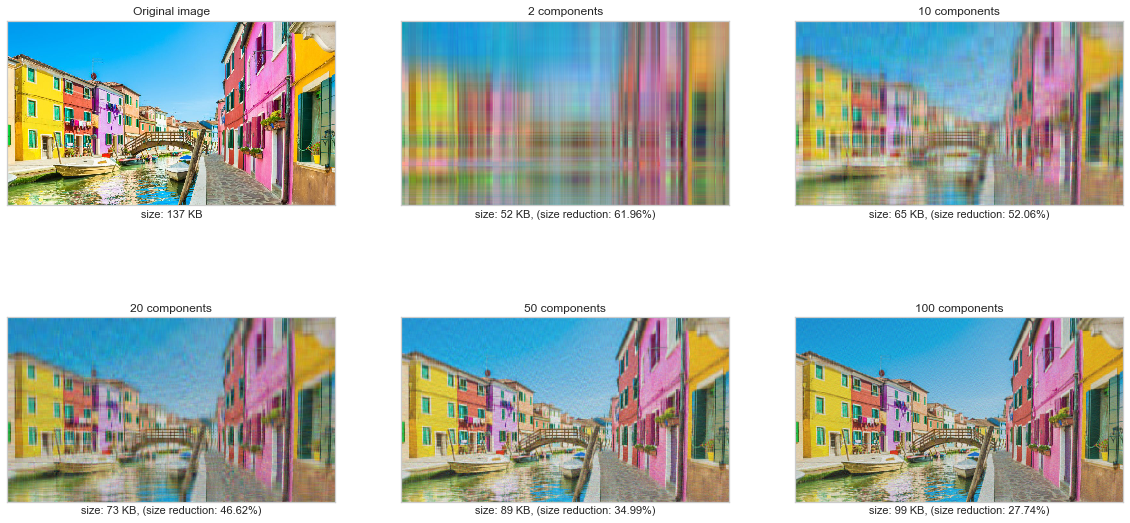

In [120]:
# split data in r, g and b arrays
image_R = base_image_array[:,:, 0]
image_G = base_image_array[:,:, 1]
image_B = base_image_array[:,:, 2]

num_components_list = [2, 10, 20, 50, 100]
images_data = []
images_data.append([base_image_array, 'Original image'])

for i, n_components in enumerate(num_components_list):
    # Train PCA for n_components and transform R, G, and B arrays
    ipca = IncrementalPCA(n_components=n_components)
    pca_img_R = ipca.inverse_transform(ipca.fit_transform(image_R))
    pca_img_G = ipca.inverse_transform(ipca.fit_transform(image_G))
    pca_img_B = ipca.inverse_transform(ipca.fit_transform(image_B))
    pca_img = normalize(np.dstack((pca_img_R, pca_img_G, pca_img_B)))
    images_data.append([pca_img, "%d components" % n_components])

plot_images_comparison(images_data)

### Selecionando o melhor valor de PCA components
No experimento anterior, conseguimos visualizar a diferença em qualidade e tamanho da imagem conforme aumentamos ou diminuímos o número de principal components. Apesar dessa abordagem mostrar imagens comprimidas que são bem próximas da original, não conseguimos medir exatamente quão similar as imagens são de forma precisa.  
Dessa forma precisamos de uma métrica que indique quão similar a imagem gerada é em relação a original. A métrica a ser utilizada é a **Variância explicada**, que mede o quão bem a imagem comprimida consegue explicar a imagem original, ou seja, quão similar ela é.  
Abaixo pegamos o valor da variância explicada cumulativa para cada cor no RGB e descobrimos um valor de n_components ideal para que nós possamos ter 95% de similaridade entre as imagens.

Numero de componentes por cor com 95% de variância:
Vermelho:  43
Verde:  95
Azul:  54


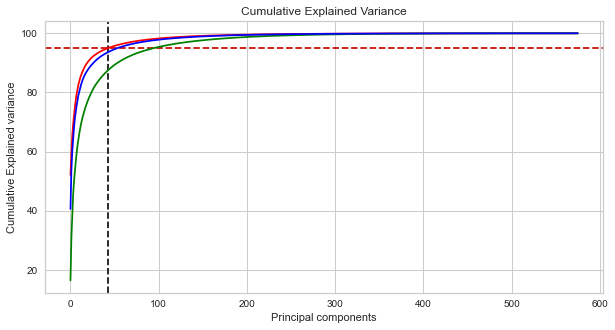

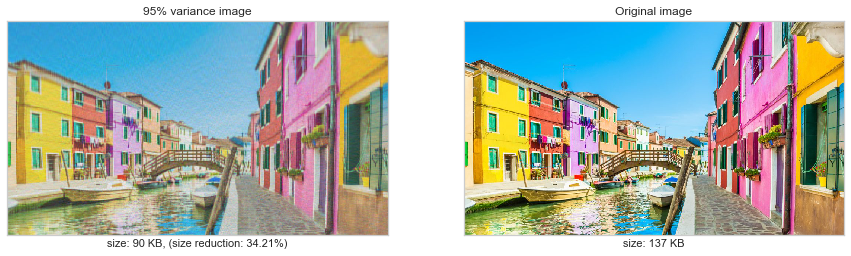

In [118]:
pca_r = PCA().fit(image_R)
pca_g = PCA().fit(image_G)
pca_b = PCA().fit(image_B)

var_cumu_r = np.cumsum(pca_r.explained_variance_ratio_)*100
var_cumu_g = np.cumsum(pca_g.explained_variance_ratio_)*100
var_cumu_b = np.cumsum(pca_b.explained_variance_ratio_)*100

k_r = np.argmax(var_cumu_r>95) 
k_g = np.argmax(var_cumu_g>95) 
k_b = np.argmax(var_cumu_b>95)
print("Numero de componentes por cor com 95% de variância:")
print("Vermelho: ", k_r)
print("Verde: ", k_g)
print("Azul: ", k_b)

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu_r, color="red")
ax = plt.plot(var_cumu_g, color="green")
ax = plt.plot(var_cumu_b, color="blue")
plt.show()

pca_r.set_params(n_components=k_r), pca_g.set_params(n_components=k_g), pca_b.set_params(n_components=k_b) 
pca_img_R = pca_r.inverse_transform(pca_r.fit_transform(image_R))
pca_img_G = pca_g.inverse_transform(pca_g.fit_transform(image_G))
pca_img_B = pca_b.inverse_transform(pca_b.fit_transform(image_B))
pca_img_result = normalize(np.dstack((pca_img_R, pca_img_G, pca_img_B)))

_, ax = plt.subplots(1,2, figsize=(15, 8))
plot_img(ax[0], pca_img_result, '95% variance image')
plot_img(ax[1], base_image_array, 'Original image', is_base_img=True)

À partir dos resultados acima, percebemos que ao selecionar valor específicos para as entradas de Red, Green e Blue, conseguimos gerar uma imagem com 95% de similaridade em relação à original. Além disso, obtivemos uma redução de tamanho significativa.

## Conclusão

O estudo da otimização do tamanho de imagens é um tema de extrema importância, através dele é possível reduzir custos de armazenamento, aumentar a velocidade de transferência de arquivos. Esse assunto é de interesse de diversas empresas grandes de tecnologia que desejam prover a melhor experiência possível para o seus usuários com o menor custo possível.  
    À partir da implementação acima, foi possível entender como os algoritmos performam nesta tarefa e como suas peculiaridades influenciam no resultado final. Comparando os resultados entre eles, podemos concluir o seguinte para cada um:
- **PCA**: O PCA obteve o melhor desempenho e conseguiu gerar imagens mais similares à original. No último experimento, que seleciona valores de k para atingir 95% de variância explicada, obtemos uma imagem parecida com a original que utiliza 34% menos memória, o que representa um ótimo resultado. Em comparação com o K-means, o PCA conseguiu representar melhor as cores e os formatos da imagem original porém, com um valor de `n_components` baixo o PCA produziu imagens que são irreconhecíveis, então para tarefas na qual queremos pegar só as principais formas da imagem, ele não seria o melhor algoritmo.
- **K-means**: O K-means, obteve um bom desempenho, mas não tão bom quanto o PCA para a imagem testada. Um dos fatos que levou o K-means a não criar imagens tão similares, é que a imagem original possui muitas cores e alguns detalhes são perdidos ao agrupar cores mais comuns. Por exemplo, nas imagens geradas pelo K-means, é perceptível que o céu que possui um leve gradiente de azul claro à azul escuro foi transformado em faixas de cores fixas. Apesar do K-means não possuir a melhor performance, é possíve perceber que para um valor baixo de K, ele ainda consegue extrair algumas características de uma imagem, o pode ser mais interessante em tarefas na qual queremos apenas pegar as formas principais da imagem.

## Referências
- https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
- https://datascience.stackexchange.com/questions/6508/k-means-incoherent-behaviour-choosing-k-with-elbow-method-bic-variance-explain
- https://math.stackexchange.com/questions/1009297/variances-for-k-means-clustering
- https://homepages.dcc.ufmg.br/~adrianov/ml/pres.pdf
- https://heartbeat.fritz.ai/a-2019-guide-to-deep-learning-based-image-compression-2f5253b4d811#6b94
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html?highlight=kmeans#sklearn.cluster.MiniBatchKMeans
- https://www.statisticshowto.com/explained-variance-variation/